In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

from qat.qpus import get_default_qpu
from qat.core import Batch, Job

from qat.fermion.transforms import transform_to_jw_basis
from qat.fermion.hamiltonians import make_embedded_model
from qat.fermion.circuits import make_shallow_circ, make_ldca_circ

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.trotterisation import make_trotterisation_routine
from qat.fermion.chemistry.ucc import construct_ucc_ansatz, guess_init_params, get_hf_ket, get_cluster_ops
from qat.qpus import get_default_qpu

from qat.plugins import ScipyMinimizePlugin, MultipleLaunchesAnalyzer

In [ ]:
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
method = "BFGS"


In [ ]:
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry.ucc import (
    convert_to_h_integrals,
    transform_integrals_to_new_basis,
)
from qat.fermion.chemistry.ucc_deprecated import (
    get_active_space_hamiltonian,
    get_cluster_ops_and_init_guess,
)
from qat.fermion.transforms import (
    get_bk_code,
    get_jw_code,
    get_parity_code,
    recode_integer,
    transform_to_bk_basis,
    transform_to_jw_basis,
    transform_to_parity_basis,
)

from openvqe.common_files.generator_excitations import (
    singlet_gsd,
    singlet_sd,
    singlet_upccgsd,
    spin_complement_gsd,
    spin_complement_gsd_twin,
    uccsd,
)

In [ ]:
import numpy as np
from itertools import product
from openvqe.common_files.fermion_util import order_fermionic_term

def _apply_transforms(cluster_ops_fr, transform, perm=0):
    if transform == "JW":
        transform_func = transform_to_jw_basis
    elif transform == "Bravyi-Kitaev":
        transform_func = transform_to_bk_basis
    elif transform == "parity_basis":
        transform_func = transform_to_parity_basis
    else:
        return
    
    cluster_ops = []
    cluster_ops_sp = []
    for y in cluster_ops_fr:
        hamilt_sp = transform_func(y)
        if hamilt_sp.terms != []:
            cluster_ops.append(y)
            cluster_ops_sp.append(hamilt_sp)
    cluster_ops += cluster_ops * perm
    cluster_ops_sp += cluster_ops_sp * perm
    pool_size = len(cluster_ops_sp)
    return pool_size, cluster_ops, cluster_ops_sp
from qat.core import Term
#from qat.dqs import FermionHamiltonian
from qat.fermion import FermionHamiltonian as Hamiltonian

import numpy as np
from itertools import product
import itertools
from itertools import combinations

from qat.core import Term
#from qat.dqs import FermionHamiltonian
from qat.fermion import FermionHamiltonian as Hamiltonian



def merge_duplicate_terms(hamiltonian):

    """
    Take a fermionic Hamiltonian and merge terms with same operator content

    Parameters
    ----------
    hamiltonian : Hamiltonian
        Of type fermionic cluster operator

    Returns
    ----------
    merged_hamiltonian: Hamiltonian
        The listed merged operators
    
    """
    

    terms = {}

    for term in hamiltonian.terms:

        key = tuple([term.op, tuple(term.qbits)])

        if key in terms.keys():

            terms[key] += term.coeff

        else:

            terms[key] = term.coeff

    terms = [Term(v, k[0], list(k[1])) for k, v in terms.items()]

    merged_hamiltonian = Hamiltonian(
        hamiltonian.nbqbits, terms=terms, constant_coeff=hamiltonian.constant_coeff
    )

    return merged_hamiltonian

import numpy as np
from itertools import product

from qat.core import Term
#from qat.dqs import FermionHamiltonian
from qat.fermion import FermionHamiltonian as Hamiltonian

def permute_fermionic_operator(fermionic_term, ind):
    """
    Perform the permutation of the two operators in index ind and ind + 1 in a fermionic Term pauli string

    Args:
        fermionic_term (Term): the fermionic term which operators we seek to permute
        ind (int): the lower index of the two consecutive creation or annihilation operators we seek to permute
    
    Returns:
        list_terms (list<Term>): the list of fermionic terms resulting of the permutation
    """
    coeff = fermionic_term.coeff
    pauli_op = fermionic_term.op
    qbits = fermionic_term.qbits

    if ind >= len(pauli_op) - 1:
        raise IndexError
    permuted_pauli_op = pauli_op[:ind] + pauli_op[ind + 1] + pauli_op[ind] + pauli_op[ind + 2:]
    permuted_qbits = qbits[:]
    permuted_qbits[ind], permuted_qbits[ind + 1] = permuted_qbits[ind + 1], permuted_qbits[ind]
    if 'c' in pauli_op[ind : ind + 2] and 'C' in pauli_op[ind : ind + 2] and qbits[ind] == qbits[ind + 1]:
        return [Term(coefficient=coeff, pauli_op=pauli_op[: ind] + pauli_op[ind + 2:], qbits=qbits[:ind] + qbits[ind + 2:]), 
                Term(coefficient=-coeff, pauli_op=permuted_pauli_op, qbits=permuted_qbits)]
    else:
        return [Term(coefficient=-coeff ,pauli_op=permuted_pauli_op , qbits=permuted_qbits)]

def order_qubits(fermionic_term):
    """
    Takes a fermionic term which pauli_op is supposed to be ordered properly, and reorder it increasing qbit numbers

    Args:
        fermionic_term (Term): the term to reorder

    Returns:
        ordered_term (Term): the reordered term
    """
    coeff = fermionic_term.coeff
    pauli_op = fermionic_term.op
    qbits = fermionic_term.qbits

    ind_c = pauli_op.index("c")
    qbits_C = qbits[:ind_c]
    qbits_c = qbits[ind_c:]
    new_qbits = []
    
    for qbits_op in [qbits_C, qbits_c]:
        qbits_temp = qbits_op[:]
        ordered = False
        while not ordered:
            ind = 0
            while ind < len(qbits_temp) - 1 and qbits_temp[ind] <= qbits_temp[ind + 1]:
                if qbits_temp[ind] == qbits_temp[ind + 1]:
                    return 
                ind += 1
            if ind < len(qbits_temp) - 1:
                ind += 1
                new_ind = 0
                while qbits_temp[new_ind] < qbits_temp[ind]:
                    new_ind += 1
                elt_not_in_order = qbits_temp.pop(ind)
                qbits_temp.insert(new_ind, elt_not_in_order)
                coeff *= (-1)**(ind - new_ind)
            else:
                ordered = True
        new_qbits += qbits_temp
    return Term(coefficient=coeff, pauli_op=pauli_op, qbits=new_qbits)

def order_fermionic_ops(fermionic_term):
    """
    Order the operators list of a fermionic_term by putting the creations operators on the left and the annihilation operators on the right, with respect to the fermionic anticommutation relations.

    Args:
         fermionic_term (Term): the term to order

    Returns:
        ordered_fermionic_terms (list<Term>): the list of ordered fermionic terms
    """
    coeff = fermionic_term.coeff
    pauli_op = fermionic_term.op
    qbits = fermionic_term.qbits

    ind_c = pauli_op.index('c')
    try:
        ind_C = pauli_op[ind_c:].index('C') + ind_c
    except ValueError:
        new_terms = [fermionic_term]
        ordered_pauli_op = True
    else:
        new_terms = []
        for new_fermionic_term in permute_fermionic_operator(fermionic_term, ind_C - 1):
            new_terms += order_fermionic_term(new_fermionic_term)
    return new_terms

def order_fermionic_term(fermionic_term):
    """
    Order any fermionic term by putting the creation operators on the left, ordered by increasing qubit numbers, and the annihilation operators on the right, ordered y increasing qubit numbers, with respect to the fermionic anticommutation relations.

    Args:
        fermionic_term (Term): the term to order

    Returns:
        ordered_fermionic_terms (list<Term>): the list of ordered fermionic terms
    """
    new_terms = order_fermionic_ops(fermionic_term)
    ordered_terms = []
    for new_term in new_terms:
        ordered_term = order_qubits(new_term)
        if ordered_term:
            ordered_terms.append(ordered_term)
    return ordered_terms





In [ ]:
def uccgsd(n_elec, orbital_number, transform):
    """
    TBD

    Parameters
    ----------
    n_elec: int
        The number of electrons

    orbital_number: int
        The number of orbitals
    
    transform: string
        type of transformation. Either 'JW', 'Bravyi-Kitaev', or 'parity_basis'
    
    Returns
    -------

    pool_size: int
        The number of the cluster operators

    cluster_ops: List<Hamiltonian>
        List of fermionic cluster operators
        
    cluster_ops_sp: List<Hamiltonian>
        List of spin cluster operators

    """
    spin_complement_single = []
    spin_complement_double = []


    term_a = [
        Term(1, "Cc", [1, 0]),
        Term(-1, "Cc", [0, 1])
        ]

    term_b = [
        Term(1, "Cc", [2, 0]),
        Term(-1, "Cc", [0, 2])
        ]
    
    term_c = [
        Term(1, "Cc", [3, 0]),
        Term(-1, "Cc", [0, 3])
        ]
    
    term_d = [
        Term(1, "Cc", [2, 1]),
        Term(-1, "Cc", [1, 2])
        ]
    
    term_e = [
        Term(1, "Cc", [3, 1]),
        Term(-1, "Cc", [1, 3])
        ]

    term_f = [
        Term(1, "Cc", [3, 2]),
        Term(-1, "Cc", [2, 3])
        ]
    hamiltonian1 = Hamiltonian(2*orbital_number, term_a)
    hamiltonian2 = Hamiltonian(2*orbital_number, term_b)
    hamiltonian3 = Hamiltonian(2*orbital_number, term_c)
    hamiltonian4 = Hamiltonian(2*orbital_number, term_d)
    hamiltonian5 = Hamiltonian(2*orbital_number, term_e)
    hamiltonian6 = Hamiltonian(2*orbital_number, term_f)
    #, term_b, term_c, term_d, term_e, term_f
    spin_complement_single.append(hamiltonian1)
    spin_complement_single.append(hamiltonian2)
    spin_complement_single.append(hamiltonian3)
    spin_complement_single.append(hamiltonian4)
    spin_complement_single.append(hamiltonian5)
    spin_complement_single.append(hamiltonian6)

    term_j = [
            Term(1, "CCcc", [0, 1, 2, 3]),
            Term(-1, "CCcc", [3, 2, 1, 0])
        ]
    
    term_h = [
            Term(1, "CCcc", [0, 2, 1, 3]),
            Term(-1, "CCcc", [3, 1, 2, 0])
        ]
    
    term_k = [
            Term(1, "CCcc", [0, 3, 1, 2]),
            Term(-1, "CCcc", [2, 1, 3, 0])
        ]
    # term_h, term_k)
    hamiltonian7 = Hamiltonian(2*orbital_number, term_j)
    hamiltonian8 = Hamiltonian(2*orbital_number, term_h)
    hamiltonian9 = Hamiltonian(2*orbital_number, term_k)

    spin_complement_double.append(hamiltonian7)
    spin_complement_double.append(hamiltonian8)
    spin_complement_double.append(hamiltonian9)




    spin_complements = spin_complement_single + spin_complement_double
    return _apply_transforms(spin_complements, transform)

In [ ]:



def uccsd(hamiltonian, n_elec, noons_full, orb_energies_full, transform):
    """
    This function is responsible for constructing the cluster operators, the MP2 initial guesses variational parameters of the UCCSD ansatz.
    It computes the cluster operators in the spin representation and the size of the pool.

    Parameters
    ----------
    hamiltonian : Hamiltonian
        The electronic structure Hamiltonian
    
    n_elec : int
        The number of electrons
    
    noons_full : List<float>
        The list of noons
    
    orb_energies_full : List<float>
        The list of orbital energies with double degeneracy
        
    transform : string
        type of transformation. Either 'JW', 'Bravyi-Kitaev', or 'parity_basis'

    Returns
    -------
    pool_size: int
        The number of the cluster operators
    cluster_ops: list[Hamiltonian]
        list of fermionic cluster operators
    cluster_ops_sp: list[Hamiltonian]
        list of spin cluster operators
    theta_MP2: list[float]
        list of parameters in the MP2 pre-screening process
    hf_init: int
        the integer corresponding to the occupation of the Hartree-Fock solution
    """

    cluster_ops, theta_MP2, hf_init = get_cluster_ops_and_init_guess(
        n_elec, noons_full, orb_energies_full, hamiltonian.hpqrs
    )
    pool_size, cluster_ops, cluster_ops_sp = _apply_transforms(cluster_ops, transform)
    return pool_size, cluster_ops, cluster_ops_sp, theta_MP2, hf_init

In [ ]:
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.99))]
basis = "sto-3g"
spin = 0
charge = 0

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True)

print(
    f" HF energy :  {info['HF']}\n",
    f"MP2 energy : {info['MP2']}\n",
    f"FCI energy : {info['FCI']}\n",
)
print(f"Number of qubits before active space selection = {rdm1.shape[0] * 2}")
orbital_number = len(orbital_energies)
nqbits = rdm1.shape[0] * 2
print("Number of qubits = ", nqbits)

from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.chemistry.ucc import (
    guess_init_params,
    get_hf_ket,
    get_cluster_ops,
)

# Wrap the hamiltonian data into the `MolecularHamiltonian` class.
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

molecule = MoleculeInfo(hamiltonian=mol_h, n_electrons=n_electrons, noons = False,  orbital_energies=orbital_energies)
print(molecule.nqbits)
print(n_electrons)

# Define the initial Hartree-Fock state
ket_hf_init = get_hf_ket(molecule.n_electrons, nqbits=molecule.nqbits)



# Get the ElectronicStructureHamiltonian
H = molecule.hamiltonian.get_electronic_hamiltonian()
print(H)

# Compute the natural orbitals occupation numbers and the basis transformation matrix
noons, basis_change = np.linalg.eigh(rdm1)

# The noons should be in decreasing order
noons= list(reversed(noons))
noons_full, orb_energies_full = [], []
for ind in range(len(noons)):
    noons_full.extend([noons[ind], noons[ind]])
    orb_energies_full.extend([orbital_energies[ind], orbital_energies[ind]])
from qat.fermion.transforms import transform_to_jw_basis, get_jw_code, recode_integer

transformation, code = transform_to_jw_basis, get_jw_code

from qat.fermion.transforms import transform_to_jw_basis, get_jw_code, recode_integer

transformation, code = transform_to_jw_basis, get_jw_code

H_sp = transformation(H)
print(H_sp)
model = H_sp
nqbits = model.nbqbits
# Encoding the initial state to new encoding
hf_init_sp = recode_integer(ket_hf_init, code(nqbits))


print("This model has the number of qubit:", model.nbqbits)


/home/huybinh/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


 HF energy :  -1.0688975010368336
 MP2 energy : -1.0891124176527813
 FCI energy : -1.103247661224499

Number of qubits before active space selection = 4
Number of qubits =  4
4
2
0.5345224352727274 * I^4 +
(-1.11580020206298+0j) * (Cc|[0, 0]) +
(-1.11580020206298+0j) * (Cc|[1, 1]) +
(-0.5861382446046437+0j) * (Cc|[2, 2]) +
(-0.5861382446046437+0j) * (Cc|[3, 3]) +
(-0.6281804678163997+0j) * (CCcc|[0, 1, 0, 1]) +
(-0.19615797899881998+0j) * (CCcc|[0, 1, 2, 3]) +
(-0.4270411541502904+0j) * (CCcc|[0, 2, 0, 2]) +
(-0.6231991331491104+0j) * (CCcc|[1, 2, 1, 2]) +
(0.19615797899881998+0j) * (CCcc|[1, 2, 0, 3]) +
(-0.6231991331491104+0j) * (CCcc|[0, 3, 0, 3]) +
(0.19615797899881998+0j) * (CCcc|[0, 3, 1, 2]) +
(-0.4270411541502904+0j) * (CCcc|[1, 3, 1, 3]) +
(-0.19615797899881998+0j) * (CCcc|[2, 3, 0, 1]) +
(-0.6546744651368693+0j) * (CCcc|[2, 3, 2, 3])
(-0.3215821345068788+0j) * I^4 +
(0.15704511695409992+0j) * (ZZ|[0, 1]) +
(0.1067602885375726+0j) * (ZZ|[0, 2]) +
(0.1557997832872776+0j) * (ZZ|

In [ ]:
n_elec = n_electrons
transform = "JW"

pool_size, cluster_ops, cluster_ops_sp = uccgsd(n_elec, orbital_number, transform)

#pool_size, cluster_ops, cluster_ops_sp,_,_ = uccsd(H, n_electrons, noons_full, orb_energies_full, "JW")
print(len(cluster_ops))

cluster_shift = []
for i in cluster_ops_sp:
    print(i)
    if i != 0:
        cluster_shift.append(i*1j)
        
print(len(cluster_shift))    
cluster_ops_sp = cluster_shift

9
0.5j * (YX|[0, 1]) +
-0.5j * (XY|[0, 1])
0.5j * (YZX|[0, 1, 2]) +
-0.5j * (XZY|[0, 1, 2])
0.5j * (YZZX|[0, 1, 2, 3]) +
-0.5j * (XZZY|[0, 1, 2, 3])
0.5j * (YX|[1, 2]) +
-0.5j * (XY|[1, 2])
0.5j * (YZX|[1, 2, 3]) +
-0.5j * (XZY|[1, 2, 3])
0.5j * (YX|[2, 3]) +
-0.5j * (XY|[2, 3])
0.125j * (YYYX|[0, 1, 2, 3]) +
-0.125j * (XXYX|[0, 1, 2, 3]) +
-0.125j * (YXYY|[0, 1, 2, 3]) +
(-0-0.125j) * (XYYY|[0, 1, 2, 3]) +
0.125j * (YXXX|[0, 1, 2, 3]) +
0.125j * (XYXX|[0, 1, 2, 3]) +
0.125j * (YYXY|[0, 1, 2, 3]) +
-0.125j * (XXXY|[0, 1, 2, 3])
0.125j * (YXXX|[0, 1, 2, 3]) +
0.125j * (XXYX|[0, 1, 2, 3]) +
0.125j * (YXYY|[0, 1, 2, 3]) +
(-0-0.125j) * (XXXY|[0, 1, 2, 3]) +
0.125j * (YYYX|[0, 1, 2, 3]) +
-0.125j * (XYXX|[0, 1, 2, 3]) +
(-0-0.125j) * (YYXY|[0, 1, 2, 3]) +
-0.125j * (XYYY|[0, 1, 2, 3])
0.125j * (YXYY|[0, 1, 2, 3]) +
-0.125j * (XXYX|[0, 1, 2, 3]) +
0.125j * (YXXX|[0, 1, 2, 3]) +
0.125j * (XXXY|[0, 1, 2, 3]) +
-0.125j * (YYYX|[0, 1, 2, 3]) +
-0.125j * (XYYY|[0, 1, 2, 3]) +
0.125j * (YYXY|[0, 

In [ ]:
from openvqe.common_files import molecule_factory

In [ ]:
model_matrix_sp = model.get_matrix(sparse=True)
from scipy.sparse.linalg import eigsh
eigval, eigvec = eigsh(model_matrix_sp, k=14)
print(eigval)
#print(eigvec)

[-1.10324766  0.51398105  0.53452244 -0.3480589  -0.60479546 -0.58127777
  0.05127057 -0.05161581 -0.58127777 -0.60479546 -0.05161581 -0.74037486
 -0.74037486 -0.74037486]


In [ ]:

import itertools
from typing import Any, List, Tuple, Optional, Dict
from bitstring import BitArray
import numpy as np

from qat.core import Term
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X

from qat.fermion.trotterisation import make_spin_hamiltonian_trotter_slice
from qat.fermion.hamiltonians import SpinHamiltonian, FermionHamiltonian
from qat.fermion.util import tobin

import scipy.optimize
from qat.fermion.chemistry.ucc_deprecated import build_ucc_ansatz
from qat.lang.AQASM import Program
from qat.qpus import get_default_qpu


def ucc_action(theta_current, hamiltonian_sp, cluster_ops_sp, hf_init_sp):
        """
        It maps the exponential of cluster operators ("cluster_ops_sp") associated by their parameters ("theta_current")
        using the CNOTS-staircase method, which is done by "build_ucc_ansatz" which creates the circuit on the top of
        the HF-state ("hf_init_sp"). Then, this function also calculates the expected value of the hamiltonian ("hamiltonian_sp").

        Parameters
        ----------
        theta_current: List<float>
            the Parameters of the cluster operators
        
        hamiltonian_sp: Hamiltonian
                Hamiltonian in the spin representation
            
        cluster_ops_sp: list[Hamiltonian]
            list of spin cluster operators
        
        hf_init_sp: int
            the integer corresponds to the hf_init (The Hartree-Fock state in integer representation) obtained by using
            "qat.fermion.transforms.record_integer".
        
        Returns
        --------
            res.value: float
                the resulted energy

        """
        qpu = 0
        prog = 0
        reg = 0
        qpu = get_default_qpu()
        prog = Program()
        reg = prog.qalloc(hamiltonian_sp.nbqbits)
        qrout = 0
        for n_term, (term, theta_term) in enumerate(zip(cluster_ops_sp, theta_current)):
            init = hf_init_sp if n_term == 0 else 0
            qprog = build_ucc_ansatz([term], init, n_steps=1)
            prog.apply(qprog([theta_term]), reg)
        circ = prog.to_circ()
        return circ

In [ ]:
import numpy as np
n_steps =1 
prog = Program()

theta_0 = [np.random.uniform(0, 2*np.pi) for i in range(len(cluster_ops_sp) * n_steps)]
theta = [prog.new_var(float, f"\\theta_{i}") for i in range(len(theta_0))]

print("The initial HF state ", hf_init_sp)

#k_lst = [6, 10, hf_init_sp] # List of the excitation
#k_lst = [12, 10, 6]
k_lst = [12]
circ = ucc_action(theta, model, cluster_ops_sp, hf_init_sp)
def create_circuit(k):
    return ucc_action(theta, model, cluster_ops_sp, hf_init_sp)


# Create and store circuits in a list
circuits_store = [create_circuit(k) for k in k_lst]

# Display the circuits
for circ_dis in circuits_store:
    circ_dis.display()

print(len(theta_0))
# The circuits_store[0] should be the initial HF state

The initial HF state  12


9


In [ ]:
qpu = get_default_qpu()
method = "BFGS"

model = H_sp
nqbits = model.nbqbits

energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
           
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)

        return energy
    
    return input_funct

circuits = circuits_store


input_funct = opt_funct(circuits, model, qpu, nqbits, energy_lists)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, options=options)

print(Optimizer)




         Current function value: -1.103248
         Iterations: 16
         Function evaluations: 633
         Gradient evaluations: 61
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -1.1032476612244815
        x: [ 4.536e+00  3.142e+00  3.142e+00  6.283e+00  6.283e+00
             4.162e+00  6.110e+00  7.461e-01  6.457e+00]
      nit: 16
      jac: [ 8.941e-08  1.490e-07  8.941e-08  8.941e-08  1.043e-07
             8.941e-08  1.937e-07  1.639e-07  4.470e-08]
 hess_inv: [[ 8.892e-01 -2.638e-01 ... -3.116e-01 -1.909e-01]
            [-2.638e-01  6.969e-01 ... -1.061e-01  4.548e-01]
            ...
            [-3.116e-01 -1.061e-01 ...  5.304e+00  7.353e+00]
            [-1.909e-01  4.548e-01 ...  7.353e+00  1.239e+01]]
     nfev: 633
     njev: 61


/home/huybinh/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


Final energy for k=1100: [-0.6733631143068273, -0.6733631143068275, -0.6733631153366432, -0.6733631155133137, -0.6733631196587224, -0.6733631138749591, -0.6733631158285107, -0.673363117174902, -0.6733631143068273, -0.673363115395043, -0.811074021386477, -0.8110740213864767, -0.8110740170020875, -0.8110740211039074, -0.8110740247467818, -0.8110740254502224, -0.8110740236285866, -0.8110740196353026, -0.8110740213864767, -0.8110740224064121, -0.8760071356281565, -0.8760071356281565, -0.8760071319708871, -0.8760071405870399, -0.8760071309824928, -0.8760071399390158, -0.8760071346191974, -0.8760071285268958, -0.8760071356281555, -0.8760071356513726, -0.9829002093807013, -0.9829002093807014, -0.9829002059857963, -0.982900212382635, -0.9829002064044232, -0.9829002122585341, -0.9829002089498934, -0.9829002057578332, -0.9829002093807017, -0.9829002094351954, -1.0660295761761587, -1.0660295761761596, -1.0660295747860933, -1.0660295745926944, -1.0660295743183688, -1.066029577001253, -1.0660295762

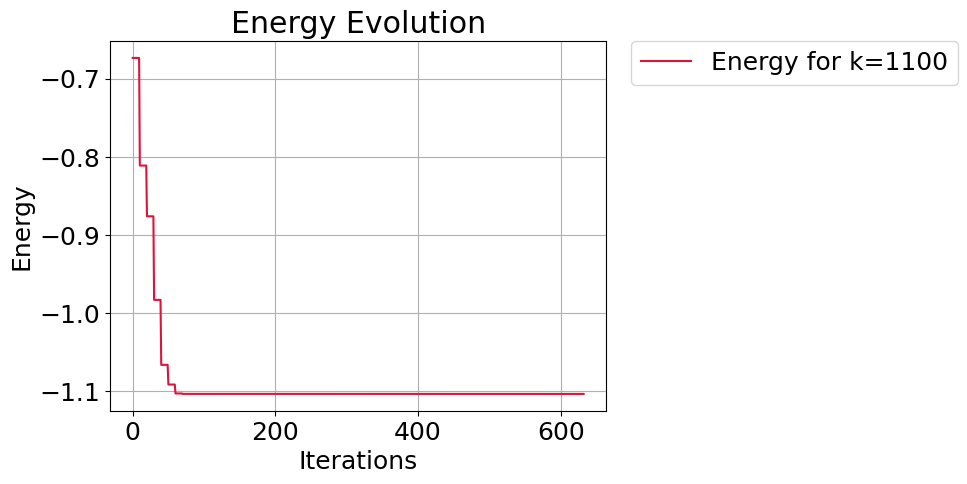

In [ ]:
import matplotlib.pyplot as plt
# Plot energy
plt.rcParams["font.size"] = 18
all_energy_lists = []

for i in range(len(circuits_store)):
    energy_list = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_list)
    plt.plot(range(len(energy_list)), energy_list, label=f"Energy for k={binary_repr(k_lst[i]).zfill(4)}", color='crimson')

    # Print the final energy for each k
    final_energy = energy_list
    print(f"Final energy for k={binary_repr(k_lst[i]).zfill(4)}: {final_energy}")

plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.grid(True)
plt.show()

In [ ]:
opt_circ_ground = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})
#print(opt_circ_ground)
theta_star = {k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)}
print("List of the update theta", theta_star)


result = qpu.submit(opt_circ_ground.to_job())
nbqbits = model.nbqbits

def get_statevector(result, nbqbits):
    statevector = []
    for sample in result:
        statevector.append({
            'state': sample.state,
            'amplitude': sample.amplitude
        })
    return statevector

    

def get_statevector_matrix(result, nbqbits):

    statevector_mat = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

stv_ground = get_statevector(result, nbqbits)
print(stv_ground)

stv_ground_mat= get_statevector_matrix(result, nbqbits)
print(stv_ground_mat)

List of the update theta {'\\theta_0': 4.536384056415237, '\\theta_1': 3.1415926498157094, '\\theta_2': 3.1415926128632776, '\\theta_3': 6.2831852950351665, '\\theta_4': 6.283185270498675, '\\theta_5': 4.161542766129561, '\\theta_6': 6.109828306950052, '\\theta_7': 0.74606623919271, '\\theta_8': 6.456882155607299}
[{'state': |0011>, 'amplitude': (-0.17248999784620941+0j)}, {'state': |0101>, 'amplitude': (-3.019265583381613e-08+0j)}, {'state': |0110>, 'amplitude': (4.1232287003232394e-08+0j)}, {'state': |1001>, 'amplitude': (2.2763715525015363e-08+0j)}, {'state': |1010>, 'amplitude': (-5.998691959829825e-09+0j)}, {'state': |1100>, 'amplitude': (0.985011269297459+0j)}]
[ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
 -1.72489998e-01+0.j  0.00000000e+00+0.j -3.01926558e-08+0.j
  4.12322870e-08+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  2.27637155e-08+0.j -5.99869196e-09+0.j  0.00000000e+00+0.j
  9.85011269e-01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.

In [ ]:
#More style
from tabulate import tabulate

# Print the statevector nicely in columns
print(tabulate(stv_ground, headers="keys", tablefmt="pretty"))

+--------+-----------------------------+
| state  |          amplitude          |
+--------+-----------------------------+
| |0011> |  (-0.17248999784620941+0j)  |
| |0101> | (-3.019265583381613e-08+0j) |
| |0110> | (4.1232287003232394e-08+0j) |
| |1001> | (2.2763715525015363e-08+0j) |
| |1010> | (-5.998691959829825e-09+0j) |
| |1100> |   (0.985011269297459+0j)    |
+--------+-----------------------------+


In [ ]:
qpu = get_default_qpu()
method = "BFGS"

model = H_sp
def_stv = stv_ground_mat
method = "BFGS"
beta_small = 33
nqbits = 4

def get_statevector_matrix(result, nbqbits):
    statevector_mat = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nbqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                

                # Check if overlap_inp is not None
                if overlap_inp is not None:
                    total_energy = energy + beta_small * overlap_inp 

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)


    return input_funct, callback
    

    

circuits = circuits_store

input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print(Optimizer)

Optimization terminated successfully.
         Current function value: -0.740375
         Iterations: 21
         Function evaluations: 240
         Gradient evaluations: 24
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.7403748572445927
        x: [ 4.536e+00  5.530e+00  1.524e+00  4.712e+00  3.958e+00
             4.225e+00  6.152e+00  7.461e-01  5.562e+00]
      nit: 21
      jac: [ 0.000e+00  6.706e-08  2.980e-08 -3.725e-08 -7.451e-08
            -1.490e-08 -1.490e-08  0.000e+00  0.000e+00]
 hess_inv: [[ 1.087e+00 -5.755e-01 ...  1.796e-01  1.254e+01]
            [-5.755e-01  4.298e+00 ... -1.116e+00 -8.097e+01]
            ...
            [ 1.796e-01 -1.116e+00 ...  1.325e+00  2.448e+01]
            [ 1.254e+01 -8.097e+01 ...  2.448e+01  1.789e+03]]
     nfev: 240
     njev: 24


In [ ]:
opt_circ_exci = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})


result = qpu.submit(opt_circ_exci.to_job())
nbqbits = model.nbqbits

stv_exci = get_statevector(result, nbqbits)

stv_exci_mat= get_statevector_matrix(result, nbqbits)
print(stv_exci_mat)

[ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
 -3.47491347e-08+0.j  0.00000000e+00+0.j  6.59439348e-01+0.j
  3.31335180e-01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  3.31335164e-01+0.j -5.87855215e-01+0.j  0.00000000e+00+0.j
 -2.33199088e-09+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j]


In [ ]:
qpu = get_default_qpu()
method = "BFGS"

model = H_sp
def_stv = stv_ground_mat
def_stv_exci = stv_exci_mat

beta_small = 33
beta_big = 44
nqbits = 4

def get_statevector_matrix(result, nbqbits):
    statevector_mat = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nbqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big, def_stv, def_stv_exci):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)
                

                # Check if overlap_inp is not None
                if overlap_inp is not None and overlap_inp_exci is not None:
                    total_energy = energy + beta_small * overlap_inp + beta_big * overlap_inp_exci

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)


    return input_funct, callback
    


circuits = circuits_store



input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big,  def_stv, def_stv_exci)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print(Optimizer)

Optimization terminated successfully.
         Current function value: -0.740375
         Iterations: 27
         Function evaluations: 400
         Gradient evaluations: 40
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.740374857244482
        x: [ 4.536e+00  3.142e+00  2.776e+00  4.545e+00  4.712e+00
             4.307e+00  5.600e+00  4.487e-01  7.311e+00]
      nit: 27
      jac: [ 0.000e+00 -5.215e-08 -6.706e-08 -8.941e-08  2.980e-08
            -3.725e-08  1.490e-08 -8.941e-08 -7.451e-09]
 hess_inv: [[ 1.262e+00  6.326e-01 ... -1.524e+00  9.845e-01]
            [ 6.326e-01  6.336e-01 ... -1.387e+00  1.119e+00]
            ...
            [-1.524e+00 -1.387e+00 ...  4.245e+00 -3.375e+00]
            [ 9.845e-01  1.119e+00 ... -3.375e+00  3.015e+00]]
     nfev: 400
     njev: 40


In [ ]:
opt_circ_exci_t = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})


result = qpu.submit(opt_circ_exci_t.to_job())
nbqbits = model.nbqbits

stv_exci_t = get_statevector(result, nbqbits)

stv_exci_mat_t= get_statevector_matrix(result, nbqbits)
print(stv_exci_mat_t)

[ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
 -1.72297978e-01+0.j  0.00000000e+00+0.j  6.10018905e-04+0.j
 -4.92416501e-05+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
 -4.46633711e-04+0.j -5.28414754e-04+0.j  0.00000000e+00+0.j
  9.85044442e-01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j]


In [ ]:
qpu = get_default_qpu()
method = "BFGS"

model = H_sp
def_stv = stv_ground_mat
def_stv_exci = stv_exci_mat
def_stv_exci_t = stv_exci_mat_t

beta_small = 33
beta_big = 44
beta_bigger = 55

nqbits = 4

def get_statevector_matrix(result, nbqbits):
    statevector_mat = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nbqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big, beta_bigger, def_stv, def_stv_exci, def_stv_exci_t):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)
                overlap_inp_exci_t = overlap(bound_circ, def_stv_exci_t)
                

                # Check if overlap_inp is not None
                if overlap_inp is not None and overlap_inp_exci is not None:
                    total_energy = energy + beta_small * overlap_inp + beta_big * overlap_inp_exci + beta_bigger * overlap_inp_exci_t

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)
                overlap_inp_exci_t = overlap(bound_circ, def_stv_exci_t)


    return input_funct, callback
    


circuits = circuits_store



input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big, beta_bigger, def_stv, def_stv_exci, def_stv_exci_t )
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print(Optimizer)

         Current function value: -0.740375
         Iterations: 105
         Function evaluations: 1492
         Gradient evaluations: 148
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.7403748503686314
        x: [ 5.375e+00  3.036e-02  1.570e+00  5.666e+00  4.765e+00
             6.334e-01  2.099e+00  5.449e+00  5.418e+00]
      nit: 105
      jac: [-2.980e-08 -5.378e-05 -6.776e-05 -1.983e-04  3.693e-05
            -1.959e-04  6.706e-08  1.877e-04  1.080e-06]
 hess_inv: [[ 1.029e+00 -1.144e+01 ... -9.237e-03  9.503e+00]
            [-1.144e+01  4.469e+03 ...  3.544e+00 -3.712e+03]
            ...
            [-9.237e-03  3.544e+00 ...  2.011e-01 -3.374e+00]
            [ 9.503e+00 -3.712e+03 ... -3.374e+00  3.084e+03]]
     nfev: 1492
     njev: 148


/home/huybinh/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [ ]:
opt_circ_exci_q = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})


result = qpu.submit(opt_circ_exci_q.to_job())
nbqbits = model.nbqbits

stv_exci_q = get_statevector(result, nbqbits)

stv_exci_mat_q= get_statevector_matrix(result, nbqbits)

print(stv_exci_mat_q)

[ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  8.20818503e-05+0.j  0.00000000e+00+0.j -6.71520308e-01+0.j
  1.10507756e-02+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  1.10651507e-02+0.j -7.40821106e-01+0.j  0.00000000e+00+0.j
  3.61175817e-05+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j]


In [ ]:
qpu = get_default_qpu()
method = "BFGS"

model = H_sp
def_stv = stv_ground_mat
def_stv_exci = stv_exci_mat
def_stv_exci_t = stv_exci_mat_t
def_stv_exci_q = stv_exci_mat_q

beta_small = 5
beta_big = 4
beta_bigger = 3
beta_biggest = 2

nqbits = 4

def get_statevector_matrix(result, nbqbits):
    statevector_mat = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nbqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big, beta_bigger, beta_biggest, def_stv, def_stv_exci, def_stv_exci_t, def_stv_exci_q):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)
                overlap_inp_exci_t = overlap(bound_circ, def_stv_exci_t)
                overlap_inp_exci_q = overlap(bound_circ, def_stv_exci_q)
                

                # Check if overlap_inp is not None
                if overlap_inp is not None and overlap_inp_exci is not None:
                    total_energy = energy + beta_small * overlap_inp + beta_big * overlap_inp_exci + beta_bigger * overlap_inp_exci_t + beta_biggest * overlap_inp_exci_q

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)
                overlap_inp_exci_t = overlap(bound_circ, def_stv_exci_t)
                overlap_inp_exci_q = overlap(bound_circ, def_stv_exci_q)


    return input_funct, callback
    


circuits = circuits_store



input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big, beta_bigger, beta_biggest, def_stv, def_stv_exci, def_stv_exci_t, def_stv_exci_q)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print(Optimizer)

Optimization terminated successfully.
         Current function value: -0.569042
         Iterations: 17
         Function evaluations: 210
         Gradient evaluations: 21
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.5690418239387948
        x: [ 5.375e+00 -1.573e-01  2.820e+00  5.235e+00  4.841e+00
             1.279e+00  2.661e+00  4.550e+00  4.508e+00]
      nit: 17
      jac: [ 7.451e-09 -2.980e-08 -2.980e-08 -7.451e-09  2.235e-08
             7.451e-09  2.235e-08  3.725e-08  1.490e-08]
 hess_inv: [[ 1.000e+00 -6.234e-04 ... -2.797e-04 -6.522e-04]
            [-6.234e-04  5.625e-01 ...  7.990e-02  4.885e-01]
            ...
            [-2.797e-04  7.990e-02 ...  1.484e-01  1.214e-01]
            [-6.522e-04  4.885e-01 ...  1.214e-01  8.914e-01]]
     nfev: 210
     njev: 21


In [ ]:
# Plot energy
plt.rcParams["font.size"] = 18
all_energy_lists = []

for i in range(len(circuits_store)):
    energy_list = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_list)
    plt.plot(range(len(energy_list)), energy_list, label=f"Energy for k={binary_repr(k_lst[i]).zfill(4)}")

    # Print the final energy for each k
    final_energy = energy_list
    print(f"Final energy for k={binary_repr(k_lst[i]).zfill(4)}: {final_energy}")

plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()